In [1]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/cpu:0', '/gpu:0']


## Load data

In [2]:
import numpy as np

from keras import backend as K

np.random.seed(42)

In [3]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

n_training_examples = x_train.shape[0]
n_testing_examples = x_test.shape[0]
print('Training data shape: {}'.format(x_train.shape))
print('Number of training examples: {}'.format(n_training_examples))
print('Number of testing examples: {}'.format(n_testing_examples))

Training data shape: (50000, 32, 32, 3)
Number of training examples: 50000
Number of testing examples: 10000


## Set hyperparameters

In [4]:
import os

wt_dir_name = 'weights'
wt_file_name = 'wrn_fine_wts.h5'
wt_file_path = os.path.join(wt_dir_name, wt_file_name)

if not os.path.exists(wt_dir_name):
    os.makedirs(wt_dir_name)

batch_size = 128
n_epochs = 60
n_classes = 100

## Preprocessing

In [5]:
import keras.utils as k_utils

X_train = x_train.astype('float32')
X_train = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0))
X_test = x_test.astype('float32')
X_test = (X_test - X_test.mean(axis=0)) / (X_test.std(axis=0))
Y_train = k_utils.to_categorical(y_train, n_classes)
Y_test = k_utils.to_categorical(y_test, n_classes)

print('Y_train shape: {}'.format(Y_train.shape))

Y_train shape: (50000, 100)


## Data generator

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=5./32,
                                   height_shift_range=5./32,
                                   horizontal_flip=True)

train_datagen.fit(X_train, seed=0, augment=True)

## Define model

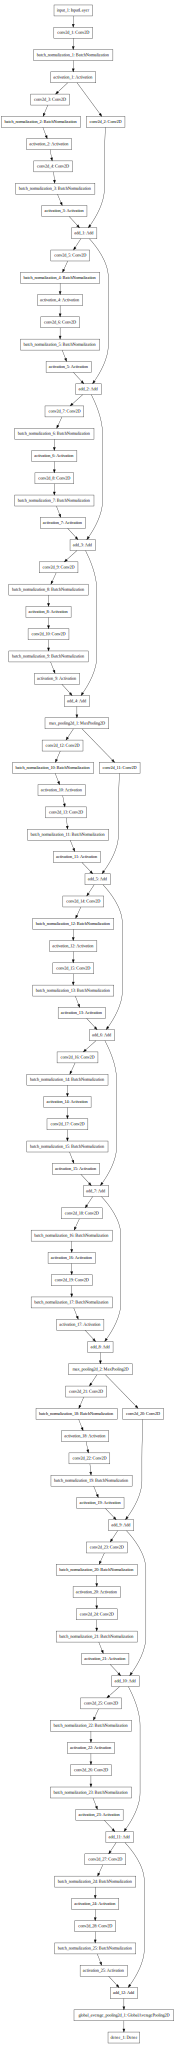

In [7]:
from keras_contrib.applications import wide_resnet as wrn

model = wrn.WideResidualNetwork(depth=28, width=8, dropout_rate=0., weights=None, classes=n_classes, activation='softmax')

from keras.utils import plot_model
plot_model(model, to_file='./saved_models/wrn_28-8.png', show_shapes=True)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Compile model

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

## Fit model

In [9]:
from keras.callbacks import ModelCheckpoint
import time

if os.path.exists(wt_file_path):
    model.load_weights(wt_file_path)
    
checkpointer = ModelCheckpoint(wt_file_name, monitor="val_acc", save_best_only=True)

t_s = time.time()
history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=n_training_examples//batch_size + 1,
                    epochs=n_epochs,
                    validation_data=(X_test, Y_test),
                    validation_steps=n_testing_examples//batch_size,
                    callbacks=[checkpointer],
                    verbose=2)

t_f = time.time()

print('Training time: {}s'.format(t_f - t_s))

Epoch 1/60
 - 320s - loss: 2.0827 - acc: 0.4494 - val_loss: 2.8376 - val_acc: 0.3669
Epoch 2/60
 - 314s - loss: 1.8168 - acc: 0.5056 - val_loss: 2.3845 - val_acc: 0.4261
Epoch 3/60
 - 315s - loss: 1.6170 - acc: 0.5518 - val_loss: 2.4767 - val_acc: 0.4233
Epoch 4/60
 - 314s - loss: 1.4547 - acc: 0.5900 - val_loss: 1.8381 - val_acc: 0.5235
Epoch 5/60
 - 314s - loss: 1.3222 - acc: 0.6221 - val_loss: 1.7673 - val_acc: 0.5440
Epoch 6/60
 - 314s - loss: 1.1889 - acc: 0.6559 - val_loss: 1.8719 - val_acc: 0.5460
Epoch 7/60
 - 314s - loss: 1.0882 - acc: 0.6800 - val_loss: 2.1437 - val_acc: 0.4972
Epoch 8/60
 - 314s - loss: 0.9919 - acc: 0.7057 - val_loss: 2.2139 - val_acc: 0.5069
Epoch 9/60
 - 314s - loss: 0.9032 - acc: 0.7284 - val_loss: 1.8944 - val_acc: 0.5443
Epoch 10/60
 - 315s - loss: 0.8283 - acc: 0.7471 - val_loss: 1.7804 - val_acc: 0.5779
Epoch 11/60
 - 314s - loss: 0.7532 - acc: 0.7692 - val_loss: 2.2500 - val_acc: 0.5340
Epoch 12/60
 - 314s - loss: 0.6762 - acc: 0.7901 - val_loss: 1.

## Evaluate model

In [10]:
scores = model.evaluate(X_test, Y_test, batch_size=batch_size)
print("\nTest %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

10000/10000 [==============================] - 20s 2ms/step

Test acc: 65.63%


## Plot accuracy and loss

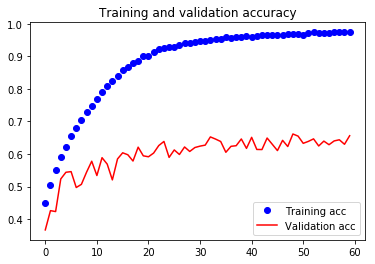

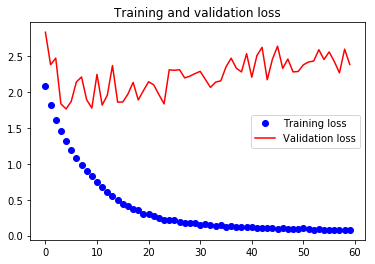

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

References
- Wide Residual Networks (BMVC 2016) http://arxiv.org/abs/1605.07146 by Sergey Zagoruyko and Nikos Komodakis.
- https://github.com/szagoruyko/wide-residual-networks 
- https://github.com/keras-team/keras-contrib
- https://github.com/titu1994/Wide-Residual-Networks